# **Project Topic**

> JAY PRABHUBHAI PATEL (Red ID : **824672518**)


## **Import Modules**

In [0]:
import numpy as np
import json,sys
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
#from google.colab import drive
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from PIL import Image, ImageDraw 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

Using TensorFlow backend.


## **Dataset**

**We uploaded dataset on google drive because it is easy to mount drive with google colab and work. If you want to run in jupyter notbook then don't run this cell.**

In [0]:
#drive.mount('/content/gdrive')
#%cd ./gdrive/My Drive/ACV

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ACV


In [0]:
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

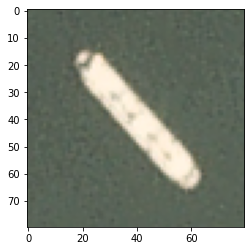

In [0]:
data = np.array(dataset['data']).astype('uint8')
img_length = 80
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])
plt.imshow(data[0])

## **Data Preprocessing**

In [0]:
input_data = np.array(dataset['data']).astype('uint8')

In [0]:
spectrum = 3
size = 80
X = input_data.reshape([-1,spectrum,size,size]).transpose([0,2,3,1])

In [0]:
output_label = np.array(dataset['labels']).astype('uint8')
y = to_categorical(output_label, num_classes=2)

**Shuffle Dataset for better result.**

In [0]:
np.random.seed(42)

In [0]:
index = np.arange(4000)
np.random.shuffle(index)

In [0]:
trainX = X[index]
trainY = y[index]

In [0]:
trainX = trainX/255

**Split dataset for training and testing. Here we used testing data as validation data.**

In [0]:
X_train, X_test , y_train, y_test = train_test_split(trainX,trainY,test_size=0.25)

**Generate batches of tensor image data with real-time data augmentation.**

In [0]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tsdata = ImageDataGenerator()

## **VGG16**

**VGG16 model, with weights pre-trained on ImageNet**

In [0]:
vggmodel = VGG16(weights='imagenet', include_top=False, input_shape=(80,80,3))
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

**Few changes according to problem.**

In [0]:
X= vggmodel.output

In [0]:
X = Flatten(name="flatten")(X)
X = Dense(512, activation="relu")(X)
X = Dropout(0.5)(X)
predictions = Dense(2, activation="softmax")(X)

In [0]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [0]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [0]:
opt = Adam(lr=0.0001)
model_final.compile(loss ='categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

**Final model summary.**

In [0]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [0]:
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

**Fit model. It will take around 20 minutes.**

In [0]:
hist = model_final.fit_generator(
	trdata.flow(X_train, y_train, batch_size=32),
	steps_per_epoch=len(X_train) // 32,
	validation_data=tsdata.flow(X_test, y_test),
	validation_steps=len(X_test) // 32,
	epochs=15,
	callbacks=[checkpoint,early])

Epoch 1/15
93/93 [==============================] - 5s 49ms/step - loss: 0.0801 - accuracy: 0.9700 - val_loss: 0.0619 - val_accuracy: 0.9869

Epoch 00001: val_loss improved from inf to 0.06186, saving model to vgg16.h5
Epoch 2/15
93/93 [==============================] - 3s 30ms/step - loss: 0.0231 - accuracy: 0.9916 - val_loss: 0.0360 - val_accuracy: 0.9855

Epoch 00002: val_loss improved from 0.06186 to 0.03604, saving model to vgg16.h5
Epoch 3/15
93/93 [==============================] - 3s 29ms/step - loss: 0.0155 - accuracy: 0.9936 - val_loss: 0.0609 - val_accuracy: 0.9897

Epoch 00003: val_loss did not improve from 0.03604
Epoch 4/15
93/93 [==============================] - 3s 30ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0047 - val_accuracy: 0.9948

Epoch 00004: val_loss improved from 0.03604 to 0.00472, saving model to vgg16.h5
Epoch 5/15
93/93 [==============================] - 3s 29ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0880 - val_accuracy: 0.9959



**Plot Validation Loss.**

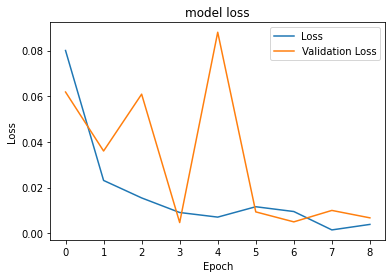

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

## **Testing**

**Get satellite image for testing.**

In [0]:
testImage = Image.open('scenes/sfbay_1.png')
p = testImage.load()

In [0]:
spectrum = 3
width = testImage.size[0]
height = testImage.size[1]

In [0]:
picVector = []
for channel in range(spectrum):
    for y in range(height):
        for x in range(width):
            picVector.append(p[x, y][channel])

In [0]:
picVector = np.array(picVector).astype('uint8')
picTensor = picVector.reshape([spectrum, height, width]).transpose(1,2,0)

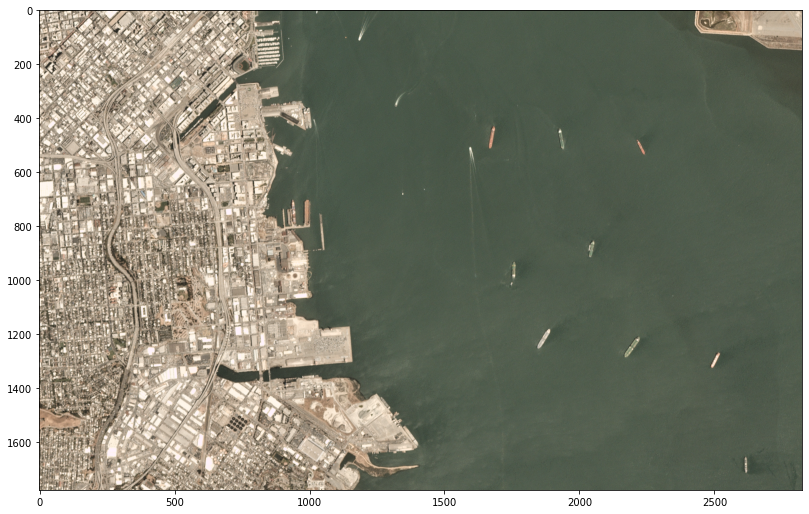

In [0]:
plt.figure(1, figsize=(15,30))
plt.subplot(3,1,1)
plt.imshow(picTensor)
plt.show()

In [0]:
picTensor = picTensor.transpose(2,0,1)

**Search on the image.**

In [0]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picTensor[0][y+i][x+j]
            area_study[1][i][j] = picTensor[1][y+i][x+j]
            area_study[2][i][j] = picTensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [0]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [0]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+th+80][x+i] = -1

X:1640 Y:430  [[0.003188   0.99681205]]


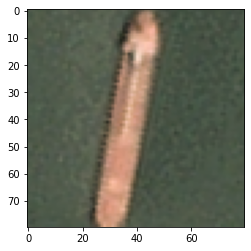

X:1890 Y:430  [[0.09158595 0.90841407]]


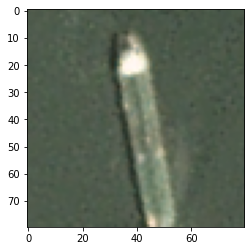

X:2180 Y:470  [[2.0405385e-04 9.9979597e-01]]


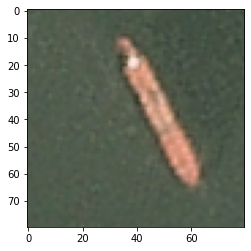

X:2000 Y:840  [[0.02215078 0.97784925]]


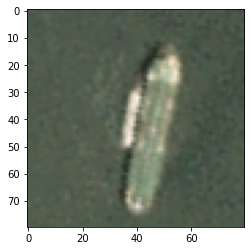

X:1710 Y:920  [[0.04446665 0.9555333 ]]


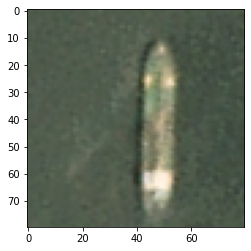

X:1050 Y:1140  [[0.0753176  0.92468244]]


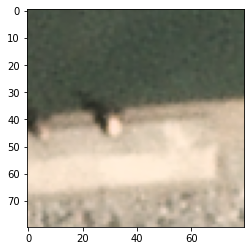

X:1840 Y:1170  [[0.02660489 0.9733951 ]]


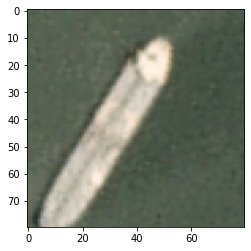

X:2170 Y:1200  [[0.08830537 0.91169465]]


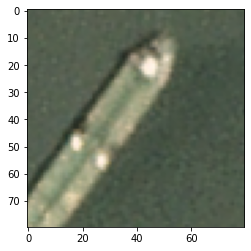

X:2470 Y:1250  [[2.7132346e-04 9.9972862e-01]]


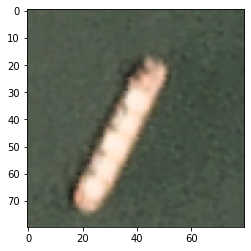

X:2570 Y:1640  [[0.01079216 0.9892078 ]]


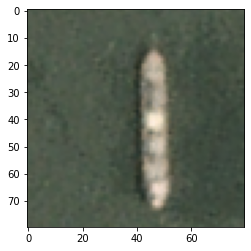

X:2740 Y:1690  

In [0]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model_final.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [0]:
for e in coordinates:
  show_ship(e[0][0], e[0][1], e[1][0])

In [0]:
picTensor = picTensor.transpose(1,2,0)
picTensor.shape

(1777, 2825, 3)

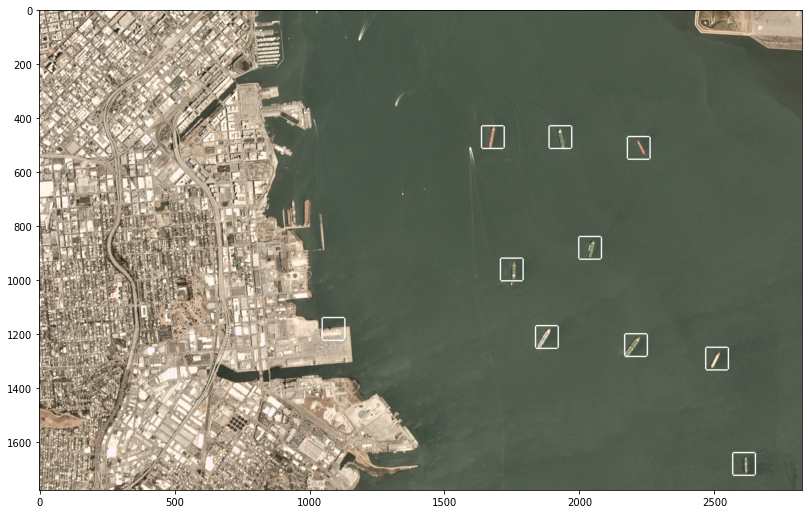

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picTensor)

plt.show()

**Let's test saved model "vgg16.h5" and analyze the result.**

In [0]:
model = load_model('vgg16.h5')

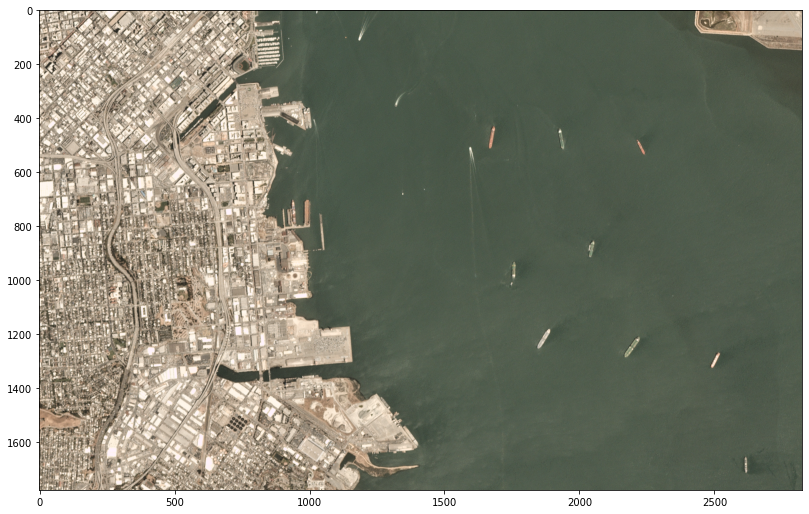

(3, 1777, 2825)

In [0]:
testImage = Image.open('scenes/sfbay_1.png')
p = testImage.load()
spectrum = 3
width = testImage.size[0]
height = testImage.size[1]
picVector = []
for channel in range(spectrum):
    for y in range(height):
        for x in range(width):
            picVector.append(p[x, y][channel])
picVector = np.array(picVector).astype('uint8')
picTensor = picVector.reshape([spectrum, height, width]).transpose(1,2,0)
plt.figure(1, figsize=(15,30))
plt.subplot(3,1,1)
plt.imshow(picTensor)
plt.show()
picTensor = picTensor.transpose(2,0,1)
picTensor.shape

X:1640 Y:430  [[0.0133377 0.9866623]]


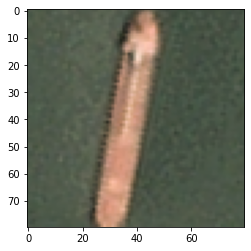

X:1890 Y:440  [[0.00277112 0.9972289 ]]


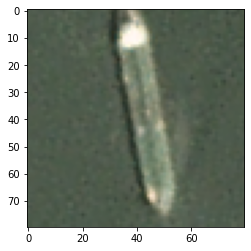

X:2180 Y:470  [[0.03265482 0.9673451 ]]


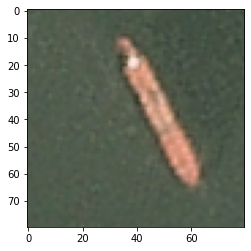

X:870 Y:480  [[0.05428243 0.9457175 ]]


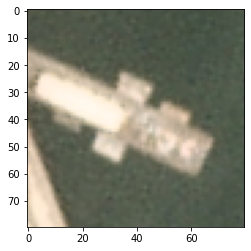

X:2010 Y:840  [[0.06055093 0.93944913]]


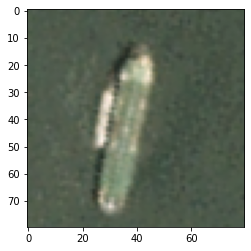

X:1720 Y:920  [[0.02839055 0.9716095 ]]


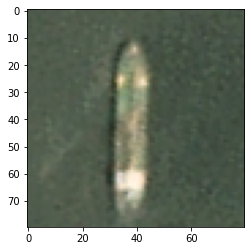

X:1830 Y:1170  [[0.03197128 0.9680287 ]]


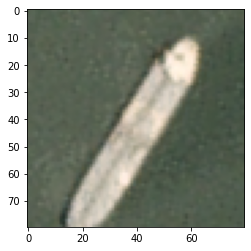

X:2160 Y:1200  [[0.06681943 0.9331805 ]]


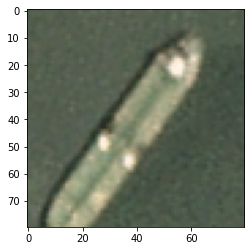

X:2460 Y:1250  [[0.05146647 0.9485336 ]]


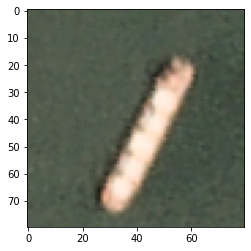

X:2570 Y:1640  [[0.08228692 0.9177131 ]]


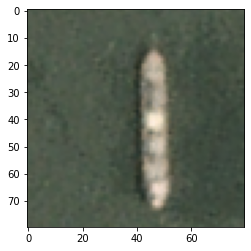

X:2740 Y:1690  

In [0]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [0]:
for e in coordinates:
  show_ship(e[0][0], e[0][1], e[1][0])

In [0]:
picTensor = picTensor.transpose(1,2,0)
picTensor.shape

(1777, 2825, 3)

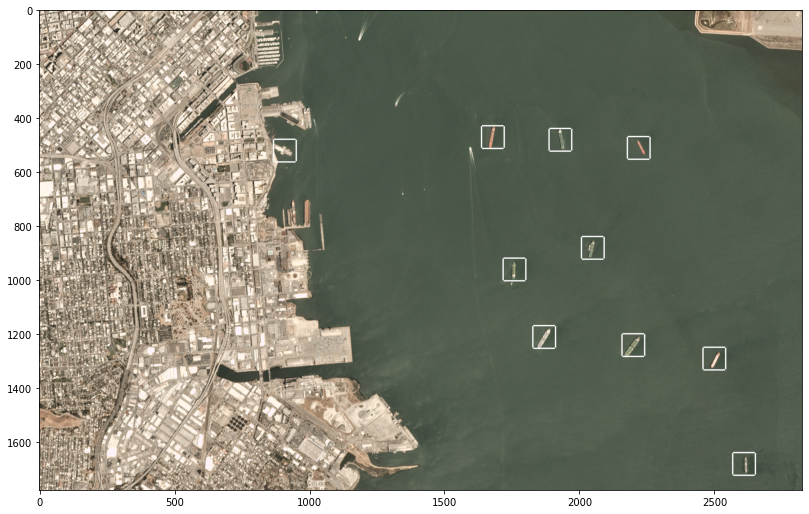

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picTensor)

plt.show()